# Jupyter notebook to test run the sun-dic DIC code

This notebook provides a detailed worked example of how to use the sun-dic code.  It provides a typical example that can easily be adjusted as required to solve new problems.  The typical workflow is to first perform the DIC analysis to get all the information that is needed for post-processing.  The resulting displacements and strains are then obtained through post-processing the results from the DIC analysis.

The notebook goes through the following basic steps that is typical for all DIC analyses using sun-dic:
- Load the required libraries
- Load the `settings.ini` file that controls how the DIC analysis is performed
- Perform the DIC analysis
- Post-process the DIC results to obtain the required displacement and strain data
  - This include the raw displacement and strain data
  - Countour plots of displacement and strain results
  - Cut-line plots of displacement and strain results

### Start by loading the required libraries

In [1]:
import numpy as np
import sundic.sundic as sdic
import sundic.post_process as sdpp
import sundic.settings as sdset

### Next load the `settings.ini` file
The settings is loaded from a text file called `settings.ini` that is located in the current working directory (the same directory where this Jupyter notebook file is located).  The `settings.ini` file controls the analysis and is well documented.  Default values are provided and in most cases the default values should provide a good starting point for the analysis.

In [2]:
# Load the settings file from the 'settings.ini' text file
settings = sdset.Settings.fromSettingsFile('settings.ini')

# Print the settings
print(settings.__repr__())


DIC Job Settings:
------------------------------------------------
                Debug Level : 1
               Image Folder : planar_images
                  CPU Count : 4
                   DIC Type : Planar
                Subset Size : 33
                  Step Size : 5
            Shape Functions : Affine
         Reference Strategy : Relative
            Starting Points : 4
         Gaussian Blur Size : 5
       Gaussian Blur StdDev : 0.0
                Datum Image : 0
               Target Image : -1
                  Increment : 1
                        ROI : [350, 120, 1100, 360]
          Background Cutoff : 25
     Optimization Algorithm : IC-GN
             Max Iterations : 50
      Convergence Threshold : 0.0001



### Now perform the DIC analysis
The DIC analysis is performed based on the values read from the settings file.  The images to be processes must be located in the **ImageFolder** variable in the settings file.  This folder is relative to the current working diretory (the directory where this Jupyter notebook is located).

The **planarDICLocal** function performs the DIC analysis and dumps the results to a binary file specified in the function call.  This binary file contains all the setting that were used during the analysis as well as all the raw DIC results.  This binary results file is used in the remaining post-process function calls to obtain the displacement and strain values and to generate graphical representations of that data.  The **planarDICLocal** function call is thus made only once and the multiple post-processing operations can be performed on the results stored in the binary results file at any give time in the future.

In [3]:
# Call the DIC analysis by providing the settings object as well as the filename that should be used to 
# store binary output data.  The analysis call is wrapped with a simple timer to see how long it takes
sdic._tic_()
sdic.planarDICLocal(settings, 'results.sdic')
sdic._toc_()


ROI : 
---------------------------------
  XStart  = 350
  YStart  = 120
  XLength = 1100
  YLength = 360

Subset Information : 
---------------------------------
  Number of subsets defined :14124
  Number of rows in subset grid :66
  Number of columns in subset grid :214

Image Pair Information :
---------------------------------
  Number of image pairs:  4

Parallel Run Information :
---------------------------------
  Starting parallel run with 4 CPUs


2024-08-15 15:41:56,113	INFO worker.py:1771 -- Started a local Ray instance.



  Splitting matrix into 1x4 submatrices

  Starting remote process for submatrix 0 0
  Starting remote process for submatrix 0 1
  Starting remote process for submatrix 0 2
  Starting remote process for submatrix 0 3

  Submatrix 0 3 completed
  Submatrix 0 0 completed
  Submatrix 0 1 completed
  Submatrix 0 2 completed
  
Image pair 0 processed
  /home/gventer/sun-dic/SUN-DIC/planar_images/img_0.tif
  /home/gventer/sun-dic/SUN-DIC/planar_images/img_1.tif

  Splitting matrix into 1x4 submatrices

  Starting remote process for submatrix 0 0
  Starting remote process for submatrix 0 1
  Starting remote process for submatrix 0 2
  Starting remote process for submatrix 0 3

  Submatrix 0 3 completed
  Submatrix 0 2 completed
  Submatrix 0 1 completed
  Submatrix 0 0 completed
  
Image pair 1 processed
  /home/gventer/sun-dic/SUN-DIC/planar_images/img_1.tif
  /home/gventer/sun-dic/SUN-DIC/planar_images/img_2.tif

  Splitting matrix into 1x4 submatrices

  Starting remote process for submat

## Start with post-processing
We will first investigate the displacement data, then the strain data.  Note that the same **resultsFile** variable used in the analysis above is passed to these functions, with the results obtained from this binary file.

## First the displacement data
The displacemen data is returned as a numpy array with the following columns

| X Coord | Y Coord | Z Coord | X Disp | Y Disp | Z Disp | Disp Magnitude |
|:------- |:------- |:------- |:------ |:------ |:------ |:-------------- |

Missing data points have displacement values of NaN and can thus be easily filtered.  The displacement data can be smoothed using a Savitsky Golay operation by specifying the **smoothWindow** and optionally the **smoothOrder** variables.  All variables for the function are described below in the code.

In [4]:
# Get the displacements
# ------------------------------------------------------------------
# Parameters:
# -----------
# - resultsFile : the binary results file name to read
# - imgPair     : the zero based image pair ID to process
# - smoothWindow: the size of the smoothing window - this is the 
#                 number of surrounding subSets to consider in 
#                 the smoothing (0 = no smoothing)
# - smoothOrder : the order of the smoothing polynomial 
#                 (default is 2)
#
# Returns:
# --------
# - results: the displacement results with the columns as outlined 
#            above
# - nRows  : the number of subset rows in the image
# - nCols  : the number of subset columns in the image
# ------------------------------------------------------------------
# NOTE - you have to specify which image pair you want to analyze by specifying
# the index of the image pair in the subSetPoints list. For example, if you want
# to analyze the first image pair you would use 0 and the last image pair would 
# -1 (or the image pair ID)
results, nRow, nCols = sdpp.getDisplacements('results.sdic', -1, smoothWindow=15)

# An easy way to drop all points that were not found during the analysis 
results = results[~np.isnan(results).any(axis=1)]

# Some basic processing of the results
print('------------------------------------------------------------------')
print('Displacement X Summary')
print('    Min: {0:10.4f}'.format(np.min(results[:, sdpp.DispComp.X_DISP])))
print('    Max: {0:10.4f}'.format(np.max(results[:, sdpp.DispComp.X_DISP])))
print('   Mean: {0:10.4f}'.format(np.mean(results[:, sdpp.DispComp.X_DISP])))
print(' StdDev: {0:10.4f}'.format(np.std(results[:, sdpp.DispComp.X_DISP])))
print('------------------------------------------------------------------')
print('Displacement Y Summary')
print('    Min: {0:10.4f}'.format(np.min(results[:, sdpp.DispComp.Y_DISP])))
print('    Max: {0:10.4f}'.format(np.max(results[:, sdpp.DispComp.Y_DISP])))
print('   Mean: {0:10.4f}'.format(np.mean(results[:, sdpp.DispComp.Y_DISP])))
print(' StdDev: {0:10.4f}'.format(np.std(results[:, sdpp.DispComp.Y_DISP])))
print('------------------------------------------------------------------')
print('Displacement Magnitude Summary')
print('    Min: {0:10.4f}'.format(np.min(results[:, sdpp.DispComp.DISP_MAG])))
print('    Max: {0:10.4f}'.format(np.max(results[:, sdpp.DispComp.DISP_MAG])))
print('   Mean: {0:10.4f}'.format(np.mean(results[:, sdpp.DispComp.DISP_MAG])))
print(' StdDev: {0:10.4f}'.format(np.std(results[:, sdpp.DispComp.DISP_MAG])))
print('------------------------------------------------------------------')

------------------------------------------------------------------
Displacement X Summary
    Min:   -41.2925
    Max:    -6.9024
   Mean:   -24.2703
 StdDev:    14.8678
------------------------------------------------------------------
Displacement Y Summary
    Min:    -7.8021
    Max:     9.0374
   Mean:     0.1936
 StdDev:     1.8073
------------------------------------------------------------------
Displacement Magnitude Summary
    Min:     6.8858
    Max:    41.2607
   Mean:    24.3452
 StdDev:    14.8565
------------------------------------------------------------------


### Make a contour plot of the displacement data
This contourplot function has a fairly large number of optional arguments to help customize the output.  Again the results may be smoothed and minimum and maximum values may be set to ignore large outliers that may appear.

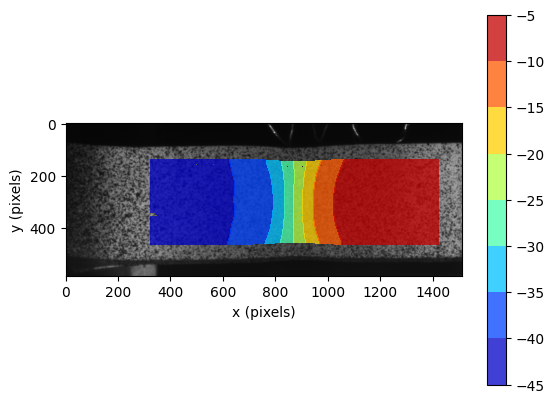

In [5]:
# ------------------------------------------------------------------
# Parameters:
# -----------
# - resultsFile : the binary results file name to read
# - imgPair     : the zero based image pair ID to process
# - dispComp    : the displacement component to plot
#                 (default is sdpp.Comp.MAG)
# - alpha       : the transparency of the contour plot
#                 (default is 0.75)
# - plotImage   : whether to plot the underlying image
#                 (default is True)
# - showPlot    : whether to show the plot here
#                 (default is True)
# - fileName    : the file name to save the plot to if required
#                 (default is '')
# - smoothWindow: the size of the smoothing window - this is the
#                 number of surrounding subSets to consider in
#                 the smoothing (0 = no smoothing)
# - smoothOrder : the order of the smoothing polynomial
#                 (default is 2)
# - maxValue    : the maximum value to plot
#                 (default is None)
# - minValue    : the minimum value to plot
#                 (default is None)
# ------------------------------------------------------------------
sdpp.plotDispContour('results.sdic',-1, dispComp=sdpp.DispComp.X_DISP,
                     alpha=0.75, plotImage=True,
                     showPlot=True, fileName='', smoothWindow=15)

### And some line cuts through the displacement image
The line cut option is useful to get 2D line graphs of a result component by specifying fixed values for either the X or the Y direction.  Multiple cutlines can be considered and the results may be interpolated or not.  If the resutls are interpolated, the exact X or Y values will be used, but gaps in the data will also be filled with interpolated data.  If the interpolation option is set to false, the nearest X or Y values to those specified will be used and gaps will appear for missing data.

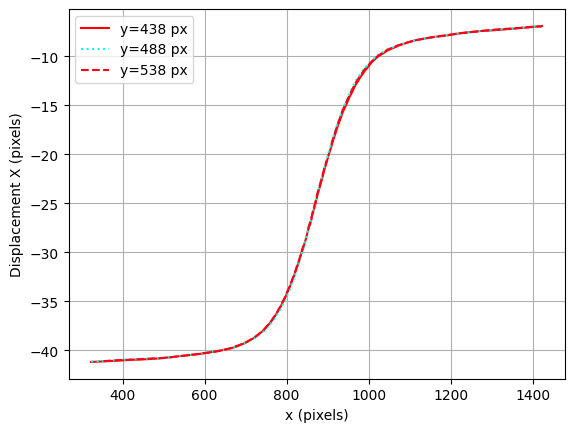

In [6]:
# ------------------------------------------------------------------
# Parameters:
# -----------
# - resultsFile : the binary results file name to read
# - imgPair     : the zero based image pair ID to process
# - dispComp    : the displacement component to plot
#                 (default is sdpp.DispComp.DISP_MAG)
# - cutComp     : the component to cut through
#                 (default is sdpp.CompID.XCoordID)
# - cutValues   : the values to cut through
#                 (default is None)
# - gridLines   : whether to plot grid lines
#                 (default is True)
# - showPlot    : whether to show the plot here
#                 (default is True)
# - fileName    : the file name to save the plot to if required
#                 (default is '')
# - smoothWindow: the size of the smoothing window - this is the
#                 number of surrounding subSets to consider in
#                 the smoothing (0 = no smoothing)
# - smoothOrder : the order of the smoothing polynomial
#                 (default is 2)
# - interpolate : whether to interpolate the data
#                 (default is False)
# ------------------------------------------------------------------
sdpp.plotDispCutLine('results.sdic', -1, dispComp=sdpp.DispComp.X_DISP, 
                     cutComp=sdpp.CompID.YCoordID,
                     cutValues=[250, 300, 350],
                     gridLines=True, showPlot=True,
                     fileName='', smoothWindow=15, interpolate=False)

## Now the strain data
Similar to the displacement data, the raw strain data and a countour and cutline plot will be created for the strain data.

The raw strain data is returned as a numpy array with the following columns

| X Coord | Y Coord | Z Coord | X Strain | Y Strain | XY Strain | VM Strain |
|:------- |:------- |:------- |:-------- |:-------- |:--------- |:--------- |

All strain components are engineering strain.

**Note** the data is always smoothed to calculate the strain data

In [7]:
# Get the strains
# ------------------------------------------------------------------
# Parameters:
# -----------
# - resultsFile : the binary results file name to read
# - imgPair     : the zero based image pair ID to process
# - smoothWindow: the size of the smoothing window - this is the
#                 number of surrounding subSets to consider in
#                 the smoothing (default is 3)
# - smoothOrder : the order of the smoothing polynomial
#                 (default is 2)
#
# Returns:
# --------
# - results: the strain results with the columns as outlined
#            above
# - nRows  : the number of subset rows in the image
# - nCols  : the number of subset columns in the image
# ------------------------------------------------------------------
results, nRows, nCols = sdpp.getStrains('results.sdic', -1, smoothWindow=15)

# Drop any results that are NaN - these are missing points
results = results[~np.isnan(results).any(axis=1)]

# Some basic processing of the results
print('------------------------------------------------------------------')
print('X Strain Summary')
print('    Min: {0:10.4f}'.format(
    np.min(results[:, sdpp.StrainComp.X_STRAIN])))
print('    Max: {0:10.4f}'.format(
    np.max(results[:, sdpp.StrainComp.X_STRAIN])))
print('------------------------------------------------------------------')
print('Y Strain Summary')
print('    Min: {0:10.4f}'.format(
    np.min(results[:, sdpp.StrainComp.Y_STRAIN])))
print('    Max: {0:10.4f}'.format(
    np.max(results[:, sdpp.StrainComp.Y_STRAIN])))
print('------------------------------------------------------------------')
print('XY Strain Summary')
print('    Min: {0:10.4f}'.format(
    np.min(results[:, sdpp.StrainComp.SHEAR_STRAIN])))
print('    Max: {0:10.4f}'.format(
    np.max(results[:, sdpp.StrainComp.SHEAR_STRAIN])))
print('------------------------------------------------------------------')
print('Von Mises Strain Summary')
print('    Min: {0:10.4f}'.format(
    np.min(results[:, sdpp.StrainComp.VM_STRAIN])))
print('    Max: {0:10.4f}'.format(
    np.max(results[:, sdpp.StrainComp.VM_STRAIN])))
print('------------------------------------------------------------------')

------------------------------------------------------------------
X Strain Summary
    Min:    -0.0383
    Max:     0.8950
------------------------------------------------------------------
Y Strain Summary
    Min:    -0.2849
    Max:     0.0296
------------------------------------------------------------------
XY Strain Summary
    Min:    -0.0760
    Max:     0.1650
------------------------------------------------------------------
Von Mises Strain Summary
    Min:     0.0033
    Max:     1.0502
------------------------------------------------------------------


### Next a contour plot of the strain data

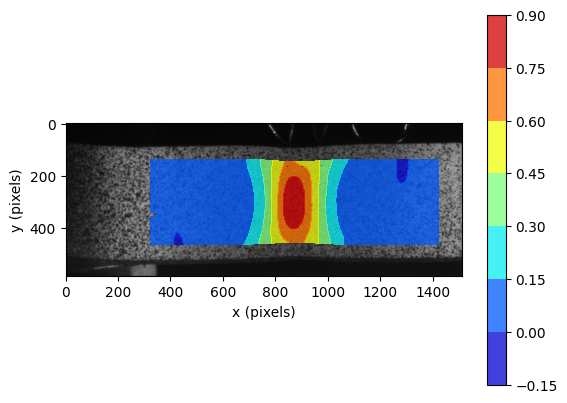

In [8]:
# ------------------------------------------------------------------
# Parameters:
# -----------
# - resultsFile : the binary results file name to read
# - imgPair     : the zero based image pair ID to process
# - dispComp    : the displacement component to plot
#                 (default is sdpp.Comp.MAG)
# - alpha       : the transparency of the contour plot
#                 (default is 0.75)
# - plotImage   : whether to plot the underlying image
#                 (default is True)
# - showPlot    : whether to show the plot here
#                 (default is True)
# - fileName    : the file name to save the plot to if required
#                 (default is '')
# - smoothWindow: the size of the smoothing window - this is the
#                 number of surrounding subSets to consider in
#                 the smoothing (0 = no smoothing)
# - smoothOrder : the order of the smoothing polynomial
#                 (default is 2)
# - maxValue    : the maximum value to plot
#                 (default is None)
# - minValue    : the minimum value to plot
#                 (default is None)
# ------------------------------------------------------------------
sdpp.plotStrainContour('results.sdic', -1, strainComp=sdpp.StrainComp.X_STRAIN,
                       alpha=0.75, plotImage=True, showPlot=True, 
                       fileName='', smoothWindow=15)

### And some line cuts through the strain image

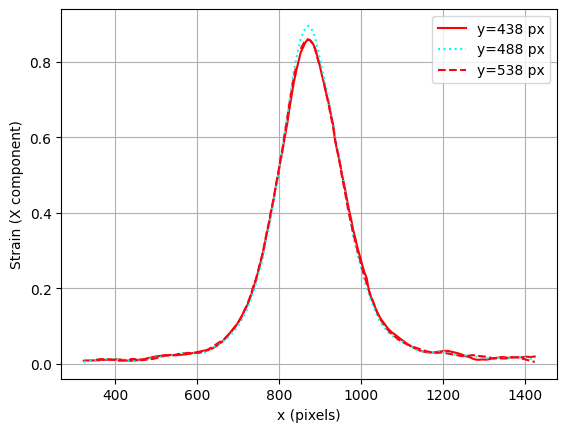

In [9]:
# ------------------------------------------------------------------
# Parameters:
# -----------
# - resultsFile : the binary results file name to read
# - imgPair     : the zero based image pair ID to process
# - strainComp  : the strain component to plot
#                 (default is sdpp.Comp.VM)
# - cutComp     : the component to cut through
#                 (default is sdpp.Comp.X)
# - cutValues   : the values to cut through
#                 (default is None)
# - gridLines   : whether to plot grid lines
#                 (default is True)
# - showPlot    : whether to show the plot here
#                 (default is True)
# - fileName    : the file name to save the plot to if required
#                 (default is '')
# - smoothWindow: the size of the smoothing window - this is the
#                 number of surrounding subSets to consider in
#                 the smoothing (0 = no smoothing)
# - smoothOrder : the order of the smoothing polynomial
#                 (default is 2)
# - interpolate : whether to interpolate the data
#                 (default is False)
# ------------------------------------------------------------------
sdpp.plotStrainCutLine('results.sdic', -1, strainComp=sdpp.StrainComp.X_STRAIN,
                        cutComp=sdpp.CompID.YCoordID,
                        cutValues=[250, 300, 350],
                        gridLines=True, showPlot=True, fileName='', smoothWindow=15, 
                        interpolate=False)